# Import Package

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
import time
import os
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,roc_curve,roc_auc_score
warnings.filterwarnings("ignore")
%matplotlib inline

# Import Data

In [2]:
dataset = pd.read_csv("https://raw.githubusercontent.com/taqiyyaghazi/knn_diabetes/main/diabetes.csv")

In [3]:
dataset.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
dataset['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [5]:
dataset.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

# Data Preparation

## Cek Missing Value

In [6]:
dataset.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

## Cek Tipe Data

In [7]:
dataset.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

## Cek Data Outlier

### Nilai Outlier dengan Boxplot

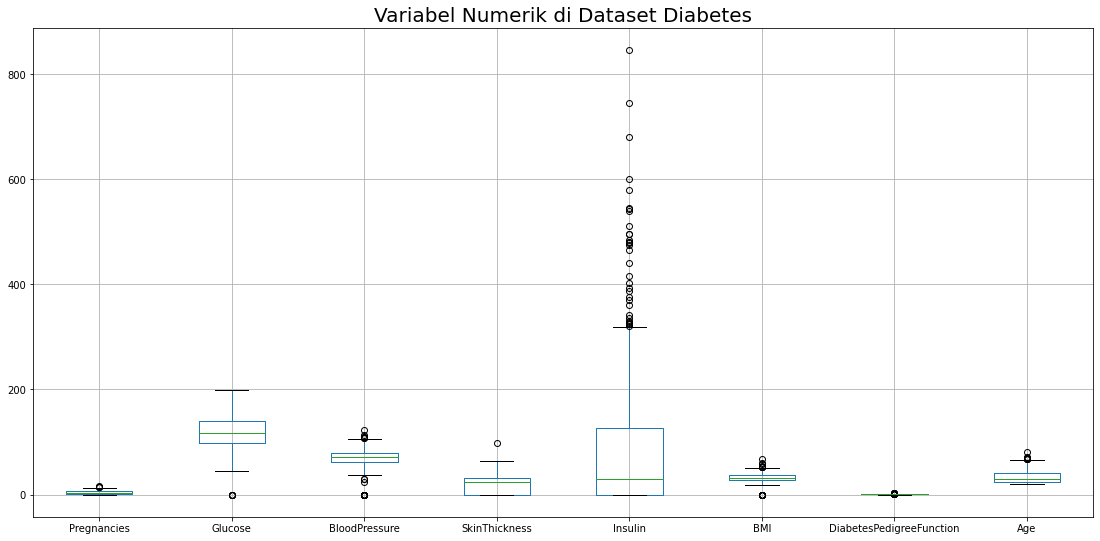

In [8]:
cols = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age']
plt.figure(figsize=(19,9))
dataset[cols].boxplot()
plt.title("Variabel Numerik di Dataset Diabetes", fontsize=20)
plt.show()

### Nilai Outlier dengan Z-Score

Sumber : https://www.analyticsvidhya.com/blog/2021/05/detecting-and-treating-outliers-treating-the-odd-one-out/

In [9]:
def detect_outliers_zscore(data):
    outliers = []
    thres = 3
    mean = np.mean(data)
    std = np.std(data)
    # print(mean, std)
    for i in data:
        z_score = (i-mean)/std
        if (np.abs(z_score) > thres):
            outliers.append(i)
    return outliers
data_outlier = {}
for col in cols:
  data_outlier[col] = detect_outliers_zscore(dataset[col])
  print("Outliers from Z-scores method (", col, ")", len(data_outlier[col]), "outlier :", data_outlier[col])



Outliers from Z-scores method ( Pregnancies ) 4 outlier : [15, 17, 14, 14]
Outliers from Z-scores method ( Glucose ) 5 outlier : [0, 0, 0, 0, 0]
Outliers from Z-scores method ( BloodPressure ) 35 outlier : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Outliers from Z-scores method ( SkinThickness ) 1 outlier : [99]
Outliers from Z-scores method ( Insulin ) 18 outlier : [543, 846, 495, 485, 495, 478, 744, 680, 545, 465, 579, 474, 480, 600, 440, 540, 480, 510]
Outliers from Z-scores method ( BMI ) 14 outlier : [0.0, 0.0, 0.0, 0.0, 0.0, 67.1, 0.0, 0.0, 59.4, 0.0, 0.0, 57.3, 0.0, 0.0]
Outliers from Z-scores method ( DiabetesPedigreeFunction ) 11 outlier : [2.2880000000000003, 1.893, 1.781, 2.329, 1.476, 2.137, 1.7309999999999999, 1.6, 2.42, 1.699, 1.6980000000000002]
Outliers from Z-scores method ( Age ) 5 outlier : [69, 72, 81, 70, 69]


### Nilai Outlier dengan IQR

In [10]:

def detect_outliers_iqr(data):
    outliers = []
    data = sorted(data)
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    # print(q1, q3)
    IQR = q3-q1
    lwr_bound = q1-(1.5*IQR)
    upr_bound = q3+(1.5*IQR)
    # print(lwr_bound, upr_bound)
    for i in data: 
        if (i<lwr_bound or i>upr_bound):
            outliers.append(i)
    return outliers
data_outlier = {}
for col in cols:
  data_outlier[col] = detect_outliers_iqr(dataset[col])
  print("Outliers from Z-scores method (", col, ")", len(data_outlier[col]), "outlier :", data_outlier[col])

Outliers from Z-scores method ( Pregnancies ) 4 outlier : [14, 14, 15, 17]
Outliers from Z-scores method ( Glucose ) 5 outlier : [0, 0, 0, 0, 0]
Outliers from Z-scores method ( BloodPressure ) 45 outlier : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 24, 30, 30, 108, 108, 110, 110, 110, 114, 122]
Outliers from Z-scores method ( SkinThickness ) 1 outlier : [99]
Outliers from Z-scores method ( Insulin ) 34 outlier : [321, 325, 325, 325, 326, 328, 330, 335, 342, 360, 370, 375, 387, 392, 402, 415, 440, 465, 474, 478, 480, 480, 485, 495, 495, 510, 540, 543, 545, 579, 600, 680, 744, 846]
Outliers from Z-scores method ( BMI ) 19 outlier : [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 52.3, 52.3, 52.9, 53.2, 55.0, 57.3, 59.4, 67.1]
Outliers from Z-scores method ( DiabetesPedigreeFunction ) 29 outlier : [1.213, 1.222, 1.224, 1.224, 1.251, 1.258, 1.268, 1.2819999999999998, 1.2919999999999998, 1.318, 1.321, 1.3530000000000002,

## Handling Data Outlier

### Handling Data Outlier BloodPressure

In [11]:
mean_blood = np.mean(dataset['BloodPressure'])
mean_blood

69.10546875

In [12]:
for i in data_outlier['BloodPressure']:
  dataset['BloodPressure'] = np.where(dataset['BloodPressure']==i, mean_blood, dataset['BloodPressure'])

detect_outliers_iqr(dataset['BloodPressure'])

[38.0, 106.0, 106.0, 106.0]

### Handling Data Outlier Insulin

In [13]:
median_insulin = np.median(dataset['Insulin'])
median_insulin

30.5

In [14]:
for i in data_outlier['Insulin']:
  dataset['Insulin'] = np.where(dataset['Insulin']==i, median_insulin, dataset['Insulin'])

detect_outliers_iqr(dataset['Insulin'])

[277.0,
 278.0,
 280.0,
 284.0,
 285.0,
 285.0,
 291.0,
 293.0,
 293.0,
 300.0,
 304.0,
 310.0,
 318.0]

### Handling Data Outlier Diabetes Pedigree Function

In [15]:
median_DPF = np.median(dataset['DiabetesPedigreeFunction'])
median_DPF

0.3725

In [16]:
for i in data_outlier['DiabetesPedigreeFunction']:
  dataset['DiabetesPedigreeFunction'] = np.where(dataset['DiabetesPedigreeFunction']==i, median_DPF, dataset['DiabetesPedigreeFunction'])

detect_outliers_iqr(dataset['DiabetesPedigreeFunction'])

[1.095,
 1.0959999999999999,
 1.101,
 1.114,
 1.127,
 1.136,
 1.138,
 1.1440000000000001,
 1.1540000000000001,
 1.159,
 1.162,
 1.1740000000000002,
 1.182,
 1.189,
 1.1909999999999998]

### Handling Data Outlier BMI

In [17]:
mean_BMI = np.mean(dataset['BMI'])
mean_BMI

31.992578124999977

In [18]:
for i in data_outlier['BMI']:
  dataset['BMI'] = np.where(dataset['BMI']==i, mean_BMI, dataset['BMI'])

detect_outliers_iqr(dataset['BMI'])

[49.6, 49.7, 50.0]

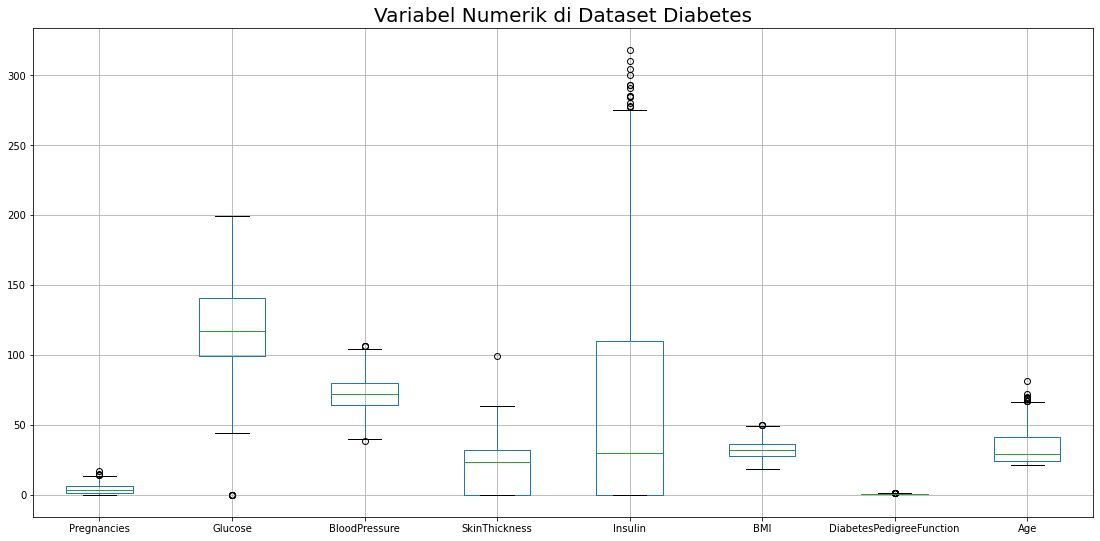

In [19]:
plt.figure(figsize=(19,9))
dataset[cols].boxplot()
plt.title("Variabel Numerik di Dataset Diabetes", fontsize=20)
plt.show()

## Inisiasi Variabel Fitur dan Label

In [20]:
X = dataset.drop('Outcome', axis=1)
y = dataset['Outcome']

## Oversampling Data

In [21]:
!pip install imbalanced-learn

In [22]:
from imblearn.over_sampling import SMOTE

In [23]:
y.value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [24]:
X, y = SMOTE().fit_resample(X, y)
print(sorted(Counter(y).items()))

[(0, 500), (1, 500)]


## Scalling Data


In [25]:
scaler =  MinMaxScaler()
# transform data
X = scaler.fit_transform(X)
print(X)

[[0.35294118 0.74371859 0.5        ... 0.48427673 0.49326146 0.48333333]
 [0.05882353 0.42713568 0.41176471 ... 0.26415094 0.24528302 0.16666667]
 [0.47058824 0.91959799 0.38235294 ... 0.16037736 0.53369272 0.18333333]
 ...
 [0.5957093  0.72297961 0.78501727 ... 0.4921457  0.36087643 0.51454903]
 [0.         0.94515832 0.95178101 ... 0.534441   0.34135552 0.30592852]
 [0.03830473 0.65899184 0.10602122 ... 0.72977771 0.40530897 0.10232294]]


# Train Model



# Data Split


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

# Training Model


## K-Nearest Neighbours

In [27]:
model = KNeighborsClassifier(n_neighbors=39, leaf_size=30)
model.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=39, p=2,
                     weights='uniform')

### Model Validation

#### Basic Validation

In [28]:
def model_validation_metrics(confusion_matrix):
  tn, fp, fn, tp = confusion_matrix.ravel()
  return (tp+tn)/(tp+tn+fp+fn),tp/(tp+fp),tp/(tp+fn)

def roc_curve_func(y_true,y_score):
  # Compute fpr, tpr, thresholds and roc auc
  fpr, tpr, thresholds = roc_curve(y_true, y_score)
  roc_auc = roc_auc_score(y_true, y_score)

  # Plot ROC curve
  plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
  plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate or (1 - Specifity)')
  plt.ylabel('True Positive Rate or (Sensitivity)')
  plt.title('Receiver Operating Characteristic')
  plt.legend(loc="lower right")

In [29]:
y_train_pred=model.predict(X_train)
y_train_pred_proba=model.predict_proba(X_train)[:,1]

cm_train=confusion_matrix(y_train, y_train_pred)

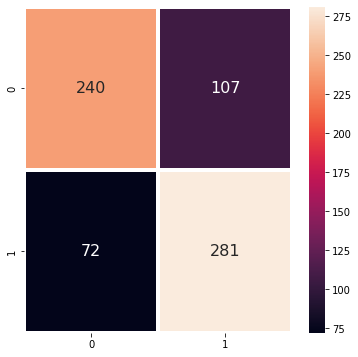

In [30]:
plt.figure(figsize=(6,6))
sns.heatmap(cm_train,annot=True,fmt=',.0f',linewidths=3, annot_kws={"fontsize":16})

In [31]:
accuracy,precision,recall=model_validation_metrics(cm_train)
print('Akurasi :', accuracy)
print('Presisi', precision)
print('Recall', recall)

Akurasi : 0.7442857142857143
Presisi 0.7242268041237113
Recall 0.7960339943342776


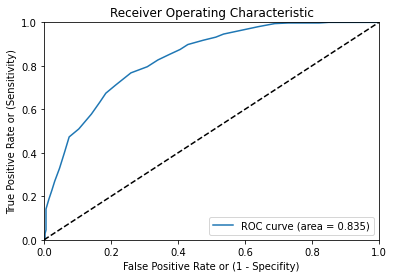

In [32]:
roc_curve_func(y_train,y_train_pred_proba)

#### Cross-Validation

In [33]:
y_train_pred=model.predict(X_train)
y_test_pred=model.predict(X_test)

In [34]:
cm_train=confusion_matrix(y_train, y_train_pred)
cm_test=confusion_matrix(y_test, y_test_pred)

In [35]:
def basic_eval(tm,cm):
  plt.figure(figsize=(6,6))
  plt.title(tm+" Evaluation")
  sns.heatmap(cm,annot=True,fmt=',.0f',linewidths=3, annot_kws={"fontsize":16})
  accuracy,precision,recall=model_validation_metrics(cm)
  print("accuracy :",accuracy)
  print("precision :",precision)
  print("recall :",recall)

accuracy : 0.7442857142857143
precision : 0.7242268041237113
recall : 0.7960339943342776


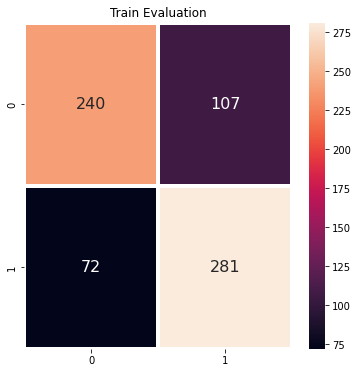

In [36]:
basic_eval('Train',cm_train)

accuracy : 0.7633333333333333
precision : 0.7261904761904762
recall : 0.8299319727891157


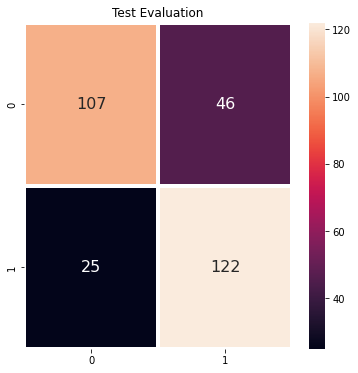

In [37]:
basic_eval('Test',cm_test)

#### Bias-variance trade-off

In [38]:
## Check on hyperparameter changing
hyper_param_list=[x for x in range(30, 41)]

In [39]:
df_trade_off=[]
for md in hyper_param_list:
  model_trade_off=KNeighborsClassifier(n_neighbors=md, weights='uniform', algorithm='auto', p=2)

  # model_base=RandomForestClassifier(n_estimators=40, max_depth=md,min_samples_split=3)
  # model_churn_trade_off=AdaBoostClassifier(base_estimator=model_base, n_estimators=15, learning_rate=0.2, random_state=321)  

  model_trade_off.fit(X_train,y_train)
  y_train_pred_temp=model_trade_off.predict(X_train)
  y_test_pred_temp=model_trade_off.predict(X_test)
  cm_train=confusion_matrix(y_train, y_train_pred_temp)
  cm_test=confusion_matrix(y_test, y_test_pred_temp)
  acc_train,p,r=model_validation_metrics(cm_train)
  acc_test,p,r =model_validation_metrics(cm_test)
  df_trade_off.append([acc_train,acc_test])
df_trade_off=pd.DataFrame(df_trade_off,columns=['train_accuracy','test_accuracy'],index=hyper_param_list)

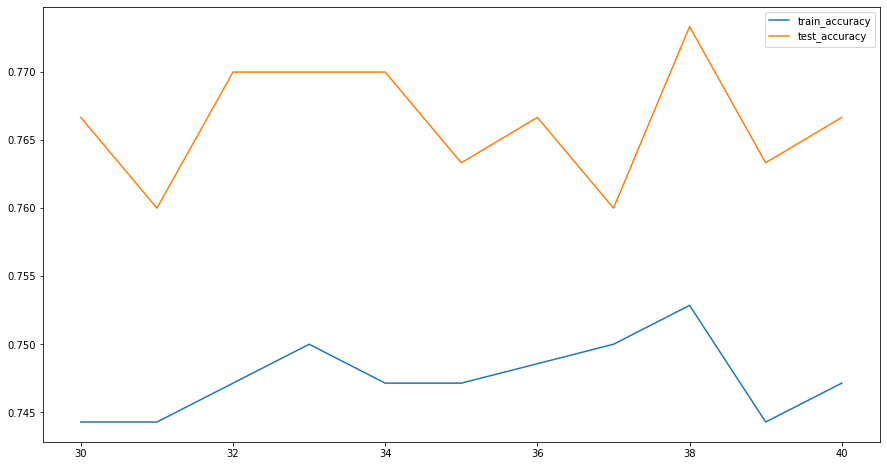

In [40]:
df_trade_off.plot(figsize=(15,8))

### Accuracy Score

In [41]:
#Import modul scikit-learn metrics 
from sklearn import metrics
# Model Accuracy
y_pred = model.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7633333333333333


In [42]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.70      0.75       153
           1       0.73      0.83      0.77       147

    accuracy                           0.76       300
   macro avg       0.77      0.76      0.76       300
weighted avg       0.77      0.76      0.76       300



## Random Forest

In [43]:
from sklearn.ensemble import RandomForestClassifier

### Train Model


In [109]:
model2 = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9, max_features='auto',
                       max_leaf_nodes=6, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=7,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [110]:
model2.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9, max_features='auto',
                       max_leaf_nodes=6, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=7,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### Cross-Validation

In [111]:
y_train_pred=model.predict(X_train)
y_test_pred=model.predict(X_test)

In [112]:
cm_train=confusion_matrix(y_train, y_train_pred)
cm_test=confusion_matrix(y_test, y_test_pred)

accuracy : 0.7442857142857143
precision : 0.7242268041237113
recall : 0.7960339943342776


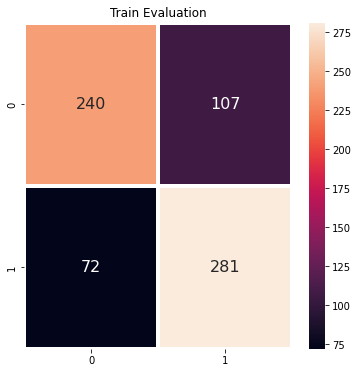

In [113]:
basic_eval('Train',cm_train)

accuracy : 0.7633333333333333
precision : 0.7261904761904762
recall : 0.8299319727891157


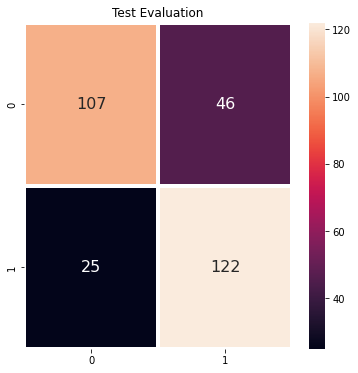

In [114]:
basic_eval('Test',cm_test)

### Bias-variance trade-off

In [103]:
hyper_param_list=[x for x in range(2, 10)]

In [104]:
df_trade_off=[]
for md in hyper_param_list:
  model_trade_off=RandomForestClassifier(min_samples_split=md, random_state=101)

  # model_base=RandomForestClassifier(n_estimators=40, max_depth=md,min_samples_split=3)
  # model_churn_trade_off=AdaBoostClassifier(base_estimator=model_base, n_estimators=15, learning_rate=0.2, random_state=321)  

  model_trade_off.fit(X_train,y_train)
  y_train_pred_temp=model_trade_off.predict(X_train)
  y_test_pred_temp=model_trade_off.predict(X_test)
  cm_train=confusion_matrix(y_train, y_train_pred_temp)
  cm_test=confusion_matrix(y_test, y_test_pred_temp)
  acc_train,p,r=model_validation_metrics(cm_train)
  acc_test,p,r =model_validation_metrics(cm_test)
  df_trade_off.append([acc_train,acc_test])
df_trade_off=pd.DataFrame(df_trade_off,columns=['train_accuracy','test_accuracy'],index=hyper_param_list)

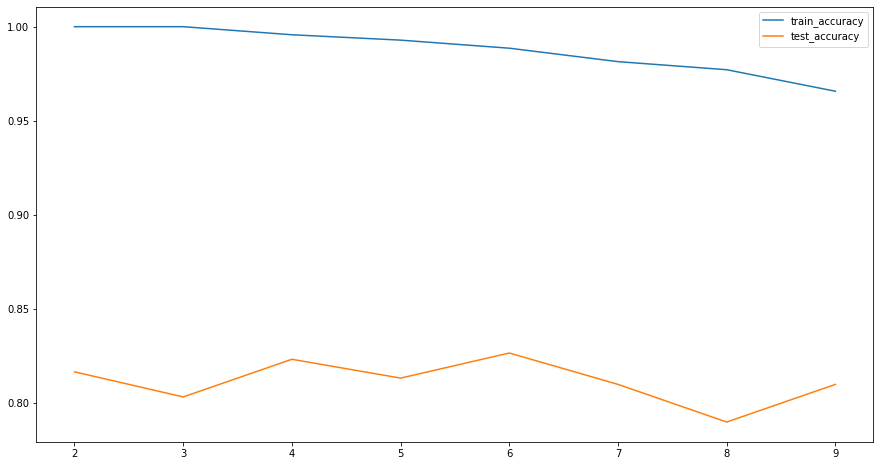

In [105]:
df_trade_off.plot(figsize=(15,8))

### Model Selection

In [53]:
from sklearn.model_selection import GridSearchCV

In [106]:
parameters = {'n_estimators':[1, 3, 5, 7],'max_depth':[3, 5, 8, 9], 'min_samples_split':[4, 6],'max_leaf_nodes':[3, 6, 11]}

clf_search1 = GridSearchCV(model2, parameters, cv=5,verbose=1)

In [107]:
L0=time.time()
clf_search1.fit(X_train,y_train)
print(time.time()-L0)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


4.167477130889893


[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed:    4.1s finished


In [108]:
clf_search1.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9, max_features='auto',
                       max_leaf_nodes=6, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=7,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### Accuracy Score

In [115]:
#Import modul scikit-learn metrics 
from sklearn import metrics
# Model Accuracy
y_pred = model2.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.79


In [116]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.78      0.79       153
           1       0.78      0.80      0.79       147

    accuracy                           0.79       300
   macro avg       0.79      0.79      0.79       300
weighted avg       0.79      0.79      0.79       300



In [118]:
df_imp = pd.DataFrame({'cols':cols,'importance':model2.feature_importances_})
df_imp = df_imp.set_index('cols')

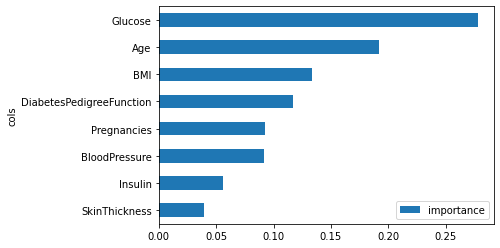

In [119]:
df_imp.sort_values('importance').plot(kind = 'barh')